# Linear Regression with Dimensionality Reduction and Regularization

This notebook implements cross-validation for dimensionality reduction and $\ell^1$ and $\ell^2$ regularization in a linear model.

The conclusion is that, to get the best performing linear model, we should first reduce the dimensionality of the data with PCA, and retain between 20 and 100 PCs as features.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

%matplotlib inline

from scripts.load_data import *

In [18]:
import sklearn.decomposition
import sklearn.linear_model
from sklearn.model_selection import train_test_split

### First, load in the training data

In [81]:
[X,y]=load_training_spectra()

### The training data consists of a near-infrared absorption spectrum for each soil sample

Each spectrum consists of measurements at 3578 wave numbers. (For more information, see the data visualization notebook (link))

In [77]:
X.head()

,7497.96,7496.04,7494.11,7492.18,7490.25,7488.32,7486.39,7484.46,7482.54,7480.61,...,617.116,615.188,613.259,611.331,609.402,607.474,605.545,603.617,601.688,599.76
0,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,0.298120,...,1.86431,1.84816,1.83288,1.81858,1.80247,1.78462,1.76644,1.75086,1.74335,1.74246
1,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,0.266766,...,1.91071,1.89728,1.88298,1.86131,1.83355,1.80581,1.78410,1.77195,1.76479,1.75437
2,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,0.313296,...,1.77356,1.76544,1.76124,1.75742,1.75113,1.74128,1.72894,1.71991,1.71562,1.71158
3,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,0.257124,...,1.73527,1.72770,1.72349,1.72149,1.71630,1.70737,1.69952,1.69356,1.68812,1.68178
4,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,0.255822,...,1.72088,1.70944,1.69711,1.68257,1.66762,1.65639,1.64929,1.64089,1.62805,1.61643


### We also know the quantities of each of the 5 target variables present in each sample

In this notebook, we will predict the quantities of these target variables from the spectra using linear models.

In [78]:
y.head()

,Ca,P,pH,SOC,Sand
0,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,-0.248601,-0.224635,-0.259551,0.064152,2.091835
3,-0.332195,-0.318014,-0.577548,-0.318719,2.118477
4,-0.438350,-0.010210,-0.699135,-0.310905,2.164148


### Why Linear Regression?

With a linear model, we will represent the value of each of the target variables as a linear combination of the features - in this case, our 3578 wavenumbers. In other words, we find a model that satisfies

$$
        Y=W^T X \\
$$

In which X is a vector of features, W is a vector of weights to be given to each feature, and Y is the output variable, or in this case since we have multiple targets, a vector of outputs. 

Linear regression is a good place to start with this data set because it is conceptually easy to understand and easy to fit, it works pretty well in many cases, and will give us a good baseline to compare our other models to. (*should expand on this for final draft*

### Fitting a linear model

Using scikitlearn, we fit this model by changing the values of the weights W in order to minimize the Euclidean distance between our observed target values, and the values predicted by the model: 

$$
      \text{best model} = \arg\!\text{min}_{\theta}\  \sqrt{\sum_\text{dataset}\left(y-w^T x\right)^2} \\
$$

We will then test how well this model generalizes to data left out of the training set by predicting the targets $Y_\text{predicted}$ of each left-out (test) sample from its inputs $X$. The performance of the model is determined by the distance between $Y_\text{predicted}$ and $Y_\text{observed}$, also known as the square-root mean squared error, or by $R^2$, which represents the proportion of the variance in $Y_\text{observed}$ that can be explained by the model.

For more detailed info on fitting linear models, go to *insert link to Charles' ipynb, other resources?*

In [132]:
model = sklearn.linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
model.fit(X_train,y_train)
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

print(test_score)

0.480583332388


### The linear model fit to every feature of the data perfectly explains the variance in the data it's trained on:

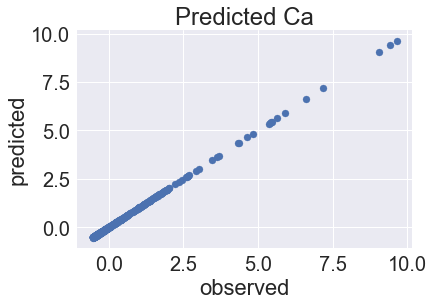

In [133]:
y_train_predict=model.predict(X_train)
y_test_predict=model.predict(X_test)
#print(y_train_predict[:,0])
y_train_plot=y_train.as_matrix()
y_test_plot=y_test.as_matrix()
#y_train_predict_plot=y_train_predict.as_matrix()

plt.scatter(y_train_plot[:,0],y_train_predict[:,0])
plt.xlabel("observed")
plt.ylabel("predicted")
plt.title("Predicted Ca")

### However, the model doesn't generalize well to the test data:

If we plot the observed vs. predicted values for each sample in the test set, we can see that a lot of the variance isn't explained by the linear model.


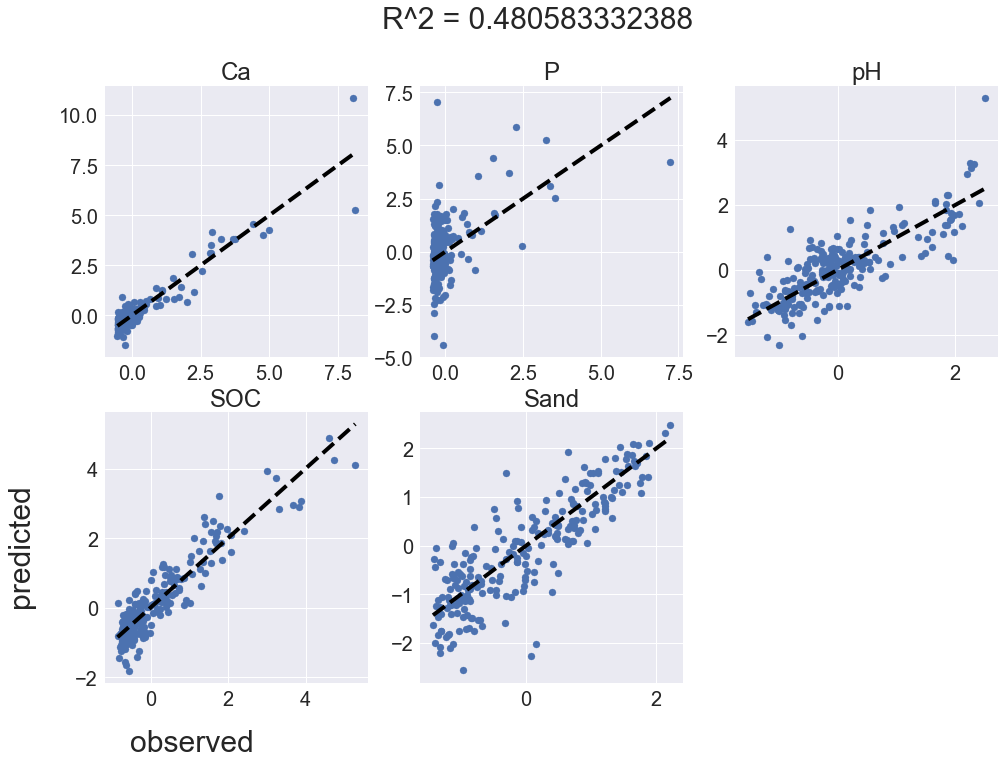

In [134]:
f, ax = plt.subplots(2, 3,figsize=(16,11))
ax=ax.ravel()
targets=y.columns

for targ in range(len(targets)):
    ax[targ].scatter(y_test_plot[:,targ],y_test_predict[:,targ])
    ax[targ].plot([y_test_plot[:,targ].min(), y_test_plot[:,targ].max()],
             [y_test_plot[:,targ].min(), y_test_plot[:,targ].max()], 'k--', lw=4)
    #ax[targ].xlabel("observed")
    #ax[targ].ylabel("predicted")
    ax[targ].set_title(targets[targ])

    
f.text(0.2, 0.04, 'observed', ha='center',fontsize=30)
f.text(0.04, 0.3, 'predicted', va='center', rotation='vertical',fontsize=30)
f.delaxes(ax[5])
f.suptitle("R^2 = " + str(test_score),fontsize=30)


### Cross-validate model to better estimate the fit

Each time we run and test the model, the score changes. This is because we are randomly splitting our data into training and test sets, and by chance some models will be fit on training sets that more accurately represent the data. To get a better estimate of the performance of the model, we will do K-fold cross-validation and use the best-performing model as a baseline. For more info, see the cross-validation notebook. *add link

In [136]:
# cross validation

model = sklearn.linear_model.LinearRegression()

num_splits = 50


train_scores = np.zeros(num_splits)
test_scores = np.zeros(num_splits)

for split_idx in range(num_splits):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        
     
    
        model.fit(X_train,y_train)
        
        train_score = model.score(X_train,y_train)
        test_score = model.score(X_test,y_test)
    
        train_scores[split_idx] = train_score
        test_scores[split_idx] = test_score

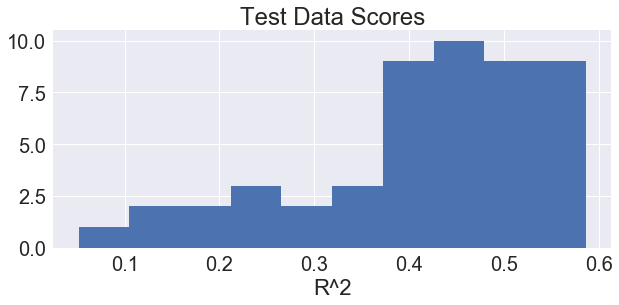

In [137]:
# plot mean test,train scores from cross validation
plt.figure(figsize=(10,4))
plt.hist(test_scores)
plt.xlabel("R^2")
plt.title("Test Data Scores")


### Why Dimensionality Reduction?

In [5]:
X.shape

(1157, 3578)

As the cell above indicates, we have more numbers observed for each datapoint than we have datapoints. This will lead many models, like linear regression, to "overfit" the data -- they will perfectly predict the outputs for data they've seen, but perform poorly on unseen data, as we saw with our linear regression model. Errors that arise from being good at a specific training set but bad at unseen data in general are called *generalization errors*.

We'd like to reduce our generalization errors. Usually, this will involve performing worse on the training set, but reducing the difference between performance on the test and training set, which can lead to better scores on the test set.

One way to achieve this is by summarizing the numbers we did observe for each datapoint with a smaller set of numbers - a process called "dimensionality reduction". We'll use a common dimensionality reduction technique called "Principal Components Analysis", or PCA. See the "Dimensionality Reduction" notebook for more on PCA. (add link)

### Cross-Validating PCA

PCA, like almost all dimensionality reduction methods, has a free parameter that is not determined by the data -- the number of dimensions that we choose to keep. A parameter that is not determined by the data is called a *hyperparameter*, because it is a parameter that controls the values we get for the rest of the parameters, and so it is above, *hyper-*, the other parameters. We will use cross-validation to determine appropriate the appropriate number of dimensions to keep.

The cells below implement cross-validation on PCA. We first select a schedule of dimensions to keep, then we produce PCA transforms for each number of dimensions, and then we run a number of cross-validation splits for each model. The scores are then aggregated across splits and plotted. In the first few cells, we only do one cross-validation split. 

If the number of splits or the length of the schedule is high, these can take a few minutes. I wouldn't recommend using more than 30 splits, since the estimates of the generalization error are quite good after only a dozen or so splits.

In [6]:
to_keep_schedule = [1,2,3,5,
                    10,20,30,50,
                    100,200,300,500,
                    #1000,
                    1157
                   ]
compressive_PCAs = []

for to_keep in to_keep_schedule:
    compressive_PCAs.append(sklearn.decomposition.PCA(n_components=to_keep).fit(X))    

In [7]:
model = sklearn.linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)

train_scores = []
test_scores = []

for compressive_PCA in compressive_PCAs:
    
    transformed_X_train = compressive_PCA.transform(X_train)
    transformed_X_test =  compressive_PCA.transform(X_test)
    
    model.fit(transformed_X_train,y_train)
    train_score = model.score(transformed_X_train,y_train)
    test_score = model.score(transformed_X_test,y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

the best number of dimensions to keep is: 200


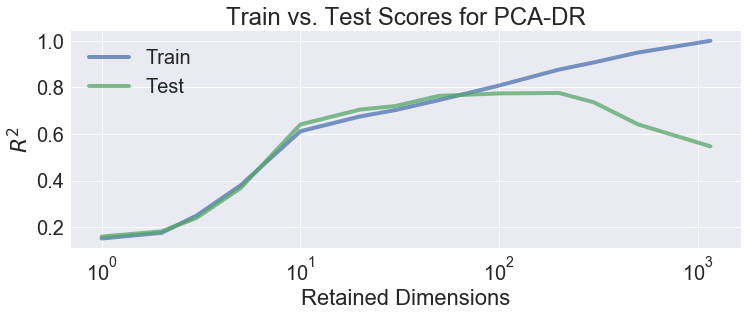

In [8]:
plt.figure(figsize=(12,4))
plt.semilogx(to_keep_schedule,train_scores,
         linewidth=4,alpha=0.75,
         label='Train')
plt.semilogx(to_keep_schedule,test_scores,
         linewidth=4,alpha=0.75,
         label='Test');
plt.xlabel("Retained Dimensions");
plt.ylabel("$R^2$")
plt.legend(); plt.title("Train vs. Test Scores for PCA-DR");

best_score_index = np.argmax(test_scores)
best_score = train_scores[best_score_index]
best_score_num_dimensions = to_keep_schedule[best_score_index]
print("the best number of dimensions to keep is: "+ str(best_score_num_dimensions))

If you run the above cell more than once, you'll get different values for the best number of dimensions to keep!

This is because the score on the test set is a random variable, just like the data values and statistics computed from those values, like the mean and standard error and $p$-value.

In [9]:
model = sklearn.linear_model.LinearRegression()

num_splits = 25

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)

train_scores = np.zeros((num_splits,len(to_keep_schedule)))
test_scores = np.zeros((num_splits,len(to_keep_schedule)))

for pca_idx, compressive_PCA in enumerate(compressive_PCAs):
    
    for split_idx in range(num_splits):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        
        transformed_X_train = compressive_PCA.transform(X_train)
        transformed_X_test =  compressive_PCA.transform(X_test)
    
        model.fit(transformed_X_train,y_train)
        
        train_score = model.score(transformed_X_train,y_train)
        test_score = model.score(transformed_X_test,y_test)
    
        train_scores[split_idx,pca_idx] = train_score
        test_scores[split_idx,pca_idx] = test_score

In [10]:
mean_train_scores = np.mean(train_scores,axis=0)
mean_test_scores = np.mean(test_scores,axis=0)

the best number of dimensions to keep is: 100


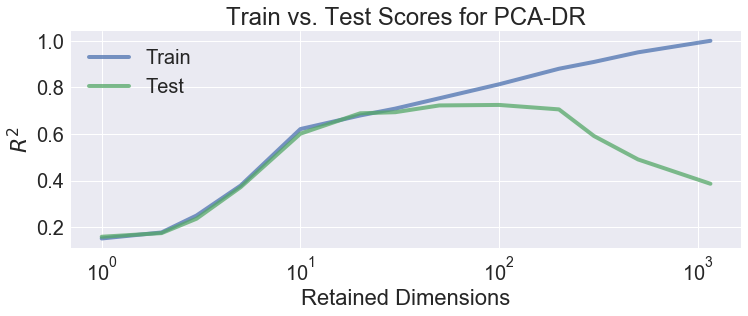

In [11]:
plt.figure(figsize=(12,4))
plt.semilogx(to_keep_schedule,mean_train_scores,
         linewidth=4,alpha=0.75,
         label='Train')
plt.semilogx(to_keep_schedule,mean_test_scores,
         linewidth=4,alpha=0.75,
         label='Test');

plt.xlabel("Retained Dimensions");
plt.ylabel("$R^2$")
plt.legend(); plt.title("Train vs. Test Scores for PCA-DR");

best_score_index = np.argmax(mean_test_scores)
best_score = mean_test_scores[best_score_index]
best_score_num_dimensions = to_keep_schedule[best_score_index]
print("the best number of dimensions to keep is: "+ str(best_score_num_dimensions))

But recall that we didn't test all of the values -- just the ones in our schedule.

We need to examine the region between 10 and 100 more closely. Let's wrap everything we've done up to this point into  a collection of functions so that we can modify it more easily.

While we're at it, let's add error bars to our plots so that we get a sense of the stability of our measurements.

In [12]:
def runCV(num_splits,compressive_PCAs,X,y,model):
    
    train_scores = np.zeros((num_splits,len(compressive_PCAs)))
    test_scores = np.zeros((num_splits,len(compressive_PCAs)))

    for pca_idx, compressive_PCA in enumerate(compressive_PCAs):

        for split_idx in range(num_splits):

            X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,)

            transformed_X_train = compressive_PCA.transform(X_train)
            transformed_X_test =  compressive_PCA.transform(X_test)

            model.fit(transformed_X_train,y_train)

            train_score = model.score(transformed_X_train,y_train)
            test_score = model.score(transformed_X_test,y_test)

            train_scores[split_idx,pca_idx] = train_score
            test_scores[split_idx,pca_idx] = test_score
            
    return train_scores, test_scores

def PCAsFromSchedule(to_keep_schedule,X):
    
    PCAs = []
    
    for to_keep in to_keep_schedule:
        PCAs.append(sklearn.decomposition.PCA(n_components=to_keep).fit(X))
    
    return PCAs

def makePlot(schedule,train_scores,test_scores):
    
    mean_train_scores = np.mean(train_scores,axis=0)
    mean_test_scores = np.mean(test_scores,axis=0)

    sd_train_scores = np.std(train_scores,axis=0,ddof=1)
    sd_test_scores = np.std(test_scores,axis=0,ddof=1)
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    
    plt.errorbar(schedule,mean_train_scores,
                 yerr=sd_train_scores,
             linewidth=4,alpha=0.75,
             label='Train')
    
    plt.errorbar(schedule,mean_test_scores,
                 yerr=sd_test_scores,
             linewidth=4,alpha=0.75,
             label='Test')
    
    plt.ylim([0,1]);

    plt.xlabel("Retained Dimensions");
    plt.ylabel("$R^2$")
    plt.legend(); plt.title("Train vs. Test Scores for PCA-DR");
    
def getBest(test_scores,to_keep_schedule):
    
    mean_test_scores = np.mean(test_scores,axis=0)
    
    best_score_index = np.argmax(mean_test_scores)
    best_score = mean_test_scores[best_score_index]
    best_score_num_dimensions = to_keep_schedule[best_score_index]
    print("the best number of dimensions to keep is: "+ str(best_score_num_dimensions))

In [13]:
def produceCVPlot(to_keep_schedule,num_splits,
                  X,y,
                  model=sklearn.linear_model.LinearRegression()):
    
    compressive_PCAs = PCAsFromSchedule(to_keep_schedule,X)
    
    train_scores, test_scores = runCV(num_splits,compressive_PCAs,X,y,model)
    
    makePlot(to_keep_schedule,train_scores,test_scores)
    getBest(test_scores,to_keep_schedule)
    
    return train_scores,test_scores

the best number of dimensions to keep is: 70


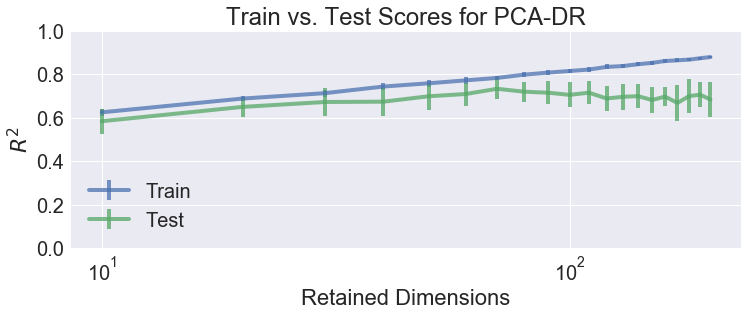

In [14]:
to_keep_schedule = [10,20,30,40,50,
                    60,70,80,90,
                    100,110,120,130,
                    140,150,160,170,
                    180,190,200
                   ]
num_splits = 25

train_scores, test_scores = produceCVPlot(to_keep_schedule,num_splits,
             X,y,
             );

On close inspection, it appears that the raw cross-validation scores don't give a way to choose between PCA dimensionality reductions to any number of dimensions between roughly 20 and roughly 100 dimensions.

The general preference, based on the Occam's razor principle, is for a simpler, rather than a more complex, model, if both models are equally supported by the data. Simplicity in our case corresponds to retaining fewer dimensions, so we should probably keep a number of dimensions in between 20 and 50, rather than between 50 and 100.

There are methods that attempt to quantify the heuristic above -- the
[Aikaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) and the
[Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion). `sklearn` implements both of these, so it's common to use them directly.

However, both criteria rely on the model class being used to reduce the dimensionality to match the process that generates the data. Here, we have no reason to really believe that our data is, in fact, multivariate Gaussian, so we should not necessarily trust the numbers provided by AIC and BIC. As such, it's probably best to stick with (quantitatively-guided) heuristics.

### Adding Regularization

Dimensionality reduction is not the only technique we can use to reduce generalization error.

In general, schemes that fight overfitting are called "regularizers". Many regularizers work by adding terms to the function we use to compute the score of a model. For example, the most common regularizers add a term to the cost that depends on the values of the parameters, with no reference to the data.

The most common class of regularizers that depend on the parameter values is the $\ell_p$, pronounced "ell-pee", class. The terms we add to the model cost look like:

$$
    \ell^p(\text{parameters}) = \sqrt[p]{\sum_\text{parameters} \lvert\text{parameter}\rvert^p}
$$

Where the vertical lines around a value $x$, e.g. $\lvert x\rvert$, mean "absolute value of $x$" and $\sqrt[p]{x}$ means "the $p$th root of $x$", the number that, when multiplied with itself $p$ times, gives us $x$.

Recall the definition of the distance from the origin for a point $(x,y,z)$ 

$$
    \text{distance}(x,y,z) = \sqrt{x^2+y^2+z^2}
$$

Rewrite this using the $\Sigma$ notation for sums:

$$
    \text{distance}(x,y,z) = \sqrt{\sum_{a = x,y,z} a^2} =\sqrt[2]{\sum_{a = x,y,z} \lvert a\rvert^2}
$$

This tells us that what we think of as "distance" is the same thing as what we're calling here "$\ell^2$". If we use $\ell^2$ regularization on our parameters, our resulting model will have smaller parameter values. When this form of regularization is applied to a regression problem, it is called *ridge regression*.

The other important case is $\ell^1$ regularization. Let's write out the definition and then simplify it:

$$
\begin{align}
    \ell^1(\text{parameters}) &= \sqrt[1]{\sum_\text{parameters} \lvert\text{parameter}\rvert^1} \\
                              &= \sum_\text{parameters} \lvert\text{parameter}\rvert
\end{align}
$$

This is just the sum of the absolute values of the parameters. This cost function tends to encourage some parameters to be exactly $0$. It's nice for when you'd like to make a model that's interpretable -- if the parameter associated with input $x$ is non-zero, then you know that it's important for making good predictions. When this regularizer is applied to regression problems, it's called *LASSO* regression.

When we use a regularization scheme that involves adding a term to our model's cost function, we generally introduce a hyperparameter, usually called $\alpha$ that tells us the relative importance of the original cost function and the regularizer term.

The cells below implement both $\ell^1$ and $\ell^2$ regularization and look for the best-performing values of $\alpha$ using cross-validation. Somewhat surprisingly, that value seems to be $0$ for this dataset (at least after we perform dimensionality reduction), indicating that we shouldn't use either of these regularizers.

### $\ell^1$ Regularization

In [138]:
def alphaPlot(alphas,train_scores,test_scores,model_type):
    
    mean_train_scores = np.mean(train_scores,axis=0)
    mean_test_scores = np.mean(test_scores,axis=0)

    sd_train_scores = np.std(train_scores,axis=0,ddof=1)
    sd_test_scores = np.std(test_scores,axis=0,ddof=1)
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    
    plt.errorbar(alphas,mean_train_scores,
                 yerr=sd_train_scores,
             linewidth=4,alpha=0.75,
             label='Train')
    
    plt.errorbar(alphas,mean_test_scores,
                 yerr=sd_test_scores,
             linewidth=4,alpha=0.75,
             label='Test')
    
    plt.ylim([0,1]);

    plt.xlabel(r"$\alpha $ value");
    plt.ylabel("$R^2$")
    plt.legend(); plt.title("Train vs. Test Scores for "+model_type);

In [139]:
to_keep = 50
compressivePCA = sklearn.decomposition.PCA(n_components=to_keep).fit(X)

num_splits = 25

eps = 0.01
alphas = np.arange(0,1.0+eps,eps)
num_alphas = len(alphas)

train_scores = np.zeros((num_splits,num_alphas))
test_scores = np.zeros((num_splits,num_alphas))

for alpha_idx,alpha in enumerate(alphas):
    
    train_score, test_score = runCV(num_splits,[compressivePCA],
                                     X,y,
                                     model=sklearn.linear_model.Lasso(alpha=alpha)
                                     );
    train_scores[:,alpha_idx] = train_score.flatten()
    test_scores[:,alpha_idx] = test_score.flatten()

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
alphaPlot(alphas,train_scores,test_scores,"LASSO")

### $\ell^2$ Regularization

In [ ]:
to_keep = 50
compressivePCA = sklearn.decomposition.PCA(n_components=to_keep).fit(X)

num_splits = 25

eps = 0.1
alphas = np.arange(0,1.0+eps,eps)
num_alphas = len(alphas)

train_scores = np.zeros((num_splits,num_alphas))
test_scores = np.zeros((num_splits,num_alphas))

for alpha_idx,alpha in enumerate(alphas):
    
    train_score, test_score = runCV(num_splits,[compressivePCA],
                                     X,y,
                                     model=sklearn.linear_model.Ridge(alpha=alpha)
                                     );
    train_scores[:,alpha_idx] = train_score.flatten()
    test_scores[:,alpha_idx] = test_score.flatten()

In [ ]:
alphaPlot(alphas,train_scores,test_scores,"Ridge")